In [1]:
import os 

In [2]:
data = "datas\\names.txt" 
data_path = os.path.join(os.getcwd(),data)

In [3]:
text_data = open(data_path,"r").read().splitlines()
type(text_data)

list

In [4]:
chars   = sorted(list(set("".join(text_data))))
stoi    = {s:i+1 for i,s in enumerate(chars)} 
stoi["."] = 0
itos    = {s:i for i,s in sorted((stoi.items()))}

In [5]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt 

## Build dataset

In [6]:
def build_dataset(dataset:list=None,block_size:int=3):

    X,Y = [],[]
    for word in dataset:

        context = [0] * block_size
        for char in word +".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # crop and append
    
    X = torch.tensor(X,device="cuda")
    Y = torch.tensor(Y,device="cuda") 
    print(X.shape,Y.shape)
    return X,Y


random.seed(42)
random.shuffle(text_data,random=random.seed(42))
n1 = int(0.8 * len(text_data))
n2 = int(0.9 * len(text_data))

x_train,y_train = build_dataset(text_data[:n1])
x_val,y_val     = build_dataset(text_data[n1:n2])
x_test,y_test   = build_dataset(text_data[n2:]) 


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Neural Network

In [78]:
n_embd      = 10
n_hidden    = 200
block_size  = 3
vocab_size  = len(itos)


## initialize the parameters 
g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0")
b1          = torch.randn((n_hidden,),                                  generator=g,device="cuda:0")
w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0")
b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") 

parameters = [C,w1,b1,w2,b2]
print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


In [8]:
n_iter      = 200000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 100000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 25000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())

      0/ 200000 :   28.5865
  25000/ 200000 :   2.6399
  50000/ 200000 :   2.8675
  75000/ 200000 :   1.9557
 100000/ 200000 :   2.1587
 125000/ 200000 :   2.7489
 150000/ 200000 :   2.3592
 175000/ 200000 :   2.4629


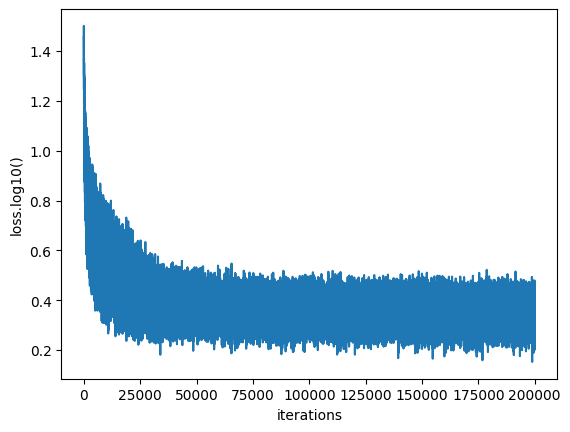

In [9]:
plt.plot((torch.tensor(loss_i).log10()))
plt.ylabel("loss.log10()")
plt.xlabel("iterations")
plt.show()

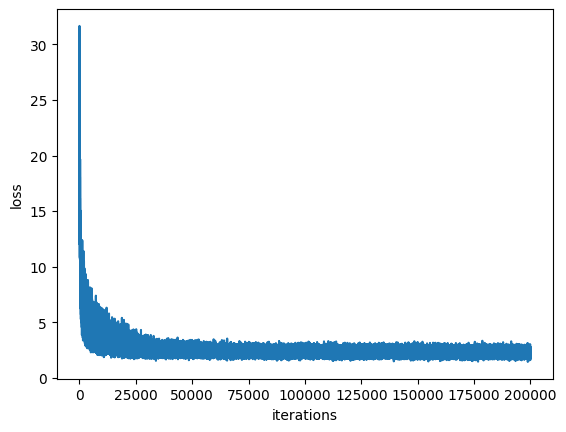

In [10]:
plt.plot(loss_i)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()

In [11]:
@torch.no_grad()       # this decorator disable gradient tracking, (no need to calulate during evaluation)
def split_loss(split):
    x,y = {
        "train" : (x_train,y_train),
        "val"   : (x_val,y_val),
        "test"  : (x_test,y_test)
    }[split]
    emb         = C[x]
    emb         = emb.view(emb.shape[0],-1) # (number_of_dataset, block_size * n_emb) (N, 3 * 10)
    h_preact    = emb @ w1 + b1             # (N,200)
    h_act       = torch.tanh(h_preact)      # (N,200)

    logits      = h_act @ w2 + b2           # (N,27)
    loss        = F.cross_entropy(logits,y) 
    print(split,loss.item())

split_loss("train")
split_loss("val")


train 2.2782018184661865
val 2.2917091846466064


In [12]:
g = torch.Generator(device="cuda").manual_seed(2147483647 + 10)

for _ in range(25):

    out     = []
    context = [0] * block_size 
    while True:
      emb     = C[torch.tensor([context])] 
      h       = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits  = h @ w2 + b2
      probs   = F.softmax(logits, dim=1)
      ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))
    

brextsn.
ezrinde.
relijahy.
rersheybelidzyonurah.
emi.
chya.
padgedey.
ton.
dhethi.
kelloni.
adstttett.
kede.
chanavi.
hrann.
juilana.
dorgh.
driel.
thah.
khoris.
adestergper.
nice.
mzem.
gie.
reighane.
shaann.


## Fixing the initial loss 

The loss we get after model training.
- 0/ 200000 :   28.5865
- 25000/ 200000 :   2.6399
- 50000/ 200000 :   2.8675
- 75000/ 200000 :   1.9557
- 100000/ 200000 :   2.1587
- 125000/ 200000 :   2.7489
- 150000/ 200000 :   2.3592
- 175000/ 200000 :   2.4629

We can say that model is improperly configured at initialization. ie, from 1st iteration loss we get is around 28 and rapidly comes out around 1 to 2. Have multiple problems in initialization of model. 

1. Messed up Initialization :    Always have an rough idea for what loss to expect at inialization. At initialization what we have do that probability of each character (number of classes),(27 characters) consider as equal distribution. At initialization we have no reason to believe any characters have more likely than other character. So we expect probability distribution that comes out to be equal/uniform distribution.

    - Probability for any character = (1/27)        = 0.03703
    - Loss                          = -(prob.log()) = 3.2958<br>
- The loss we get by uniform distribution is much lower than what we get from initial initialization. 
- Initialize the parameters roughly zeros,logits do't have to be zeros they just have to be equal. 
    

In [32]:
## rough output from sample model, 
logits  = torch.tensor([0.1,0.1,0.1,0.1]) 
                                            # probs =  logits / logits.sum()  ======= alternate method of softmax. 
probs   = F.softmax(logits,dim=0)           # we got uniform distribution 0.25 for all data points. 
loss    = -probs[2].log()                   # 
logits,probs,loss


(tensor([0.1000, 0.1000, 0.1000, 0.1000]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [42]:
## rough output from sample model, 
logits  = torch.tensor([0.1,0.56,0.1,0.1]) 
                                            # probs =  logits / logits.sum()  ======= alternate method of softmax. 
probs   = F.softmax(logits,dim=0)           # we got uniform distribution 0.25 for all data points. 
loss    = -probs[1].log()                   # 
logits,probs,loss


# in this case for, getting 0.56 element from dataset and it's probability is 0.3465.actually 34.56%

(tensor([0.1000, 0.5600, 0.1000, 0.1000]),
 tensor([0.2181, 0.3456, 0.2181, 0.2181]),
 tensor(1.0626))

In [79]:
n_iter      = 200000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 100000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 25000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())
    break

      0/ 200000 :   28.5865


In [82]:
loss.item()

28.58652114868164

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1.,
        0., 0., 0., 1., 5., 2., 2., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([-2.69724522e+01, -2.57462234e+01, -2.45199966e+01, -2.32937679e+01,
        -2.20675411e+01, -2.08413124e+01, -1.96150856e+01, -1.83888569e+01,
        -1.71626301e+01, -1.59364014e+01, -1.47101736e+01, -1.34839458e+01,
        -1.22577181e+01, -1.10314903e+01, -9.80526257e+00, -8.57903481e+00,
        -7.35280657e+00, -6.12657881e+00, -4.90035105e+00, -3.67412329e+00,
        -2.44789553e+00, -1.22166765e+00,  4.56024148e-03,  1.23078811e+00,
         2.45701599e+00,  3.68324375e+00,  4.90947151e+00,  6.13569927e+00,
         7.36192703e+00,  8.58815479e+00,  9.81438255e+00,  1.10406103e+01,
         1.22668390e+01,  1.34930668e+01,  1.47192945e+01,  1.59455223e+01,
         1.71717491e+01,  1.83979778e+01,  1.96242065e+01,  2.08504333e+01,
         2.207

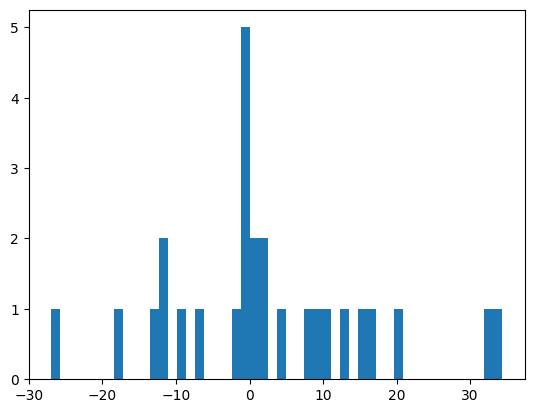

In [95]:
plt.hist(logits[0].cpu().detach(),bins=50)

In [98]:
logits  = torch.tensor([0.65,0.56,0.1,0.75]) 
probs   = F.softmax(logits,dim=0)          
loss    = -probs.log()                  
logits,probs,loss

(tensor([0.6500, 0.5600, 0.1000, 0.7500]),
 tensor([0.2781, 0.2541, 0.1604, 0.3073]),
 tensor([1.2798, 1.3698, 1.8298, 1.1798]))

: 